In [18]:
# Except otherwise noted figures are adapted from: https://github.com/ageron/handson-ml2

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.special import expit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

plt.style.use('science')
IMAGES_PATH = "../figures/"
os.makedirs(IMAGES_PATH, exist_ok=True)
get_path = lambda fname, format : os.path.join(IMAGES_PATH, fname+"."+format)
savefig = lambda fname, format : plt.savefig(get_path(fname, format), format=format)

In [21]:
def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=20)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

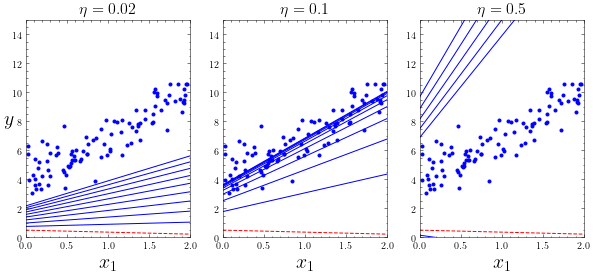

In [22]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance

theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)

lin_reg = LinearRegression()
lin_reg.fit(X, y)

eta = 0.1  # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

X_new_b.dot(theta)

theta_path_bgd = []

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))

plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=20)

plt.subplot(132)
plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)

plt.subplot(133)
plot_gradient_descent(theta, eta=0.5)

savefig("gradient_descent_plot", "pdf")
plt.show()

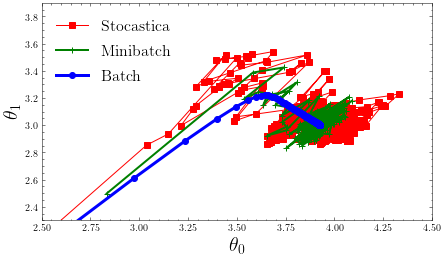

In [24]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stocastica")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Minibatch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20)
plt.axis([2.5, 4.5, 2.3, 3.9])

savefig("gradient_descent_paths_plot", "pdf")
plt.show()

In [11]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=10)

    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="addestramento")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="validazione")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Dimensione del training set", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)

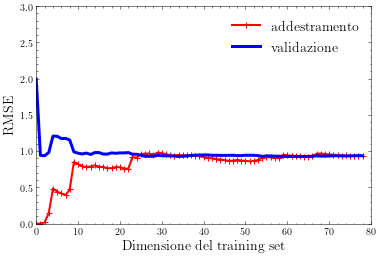

In [12]:
for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
        ("poly_features", polybig_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)

lin_reg = LinearRegression()
plt.figure(figsize=(6,4))
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])

savefig("underfitting_learning_curves_plot", "pdf")
plt.show()

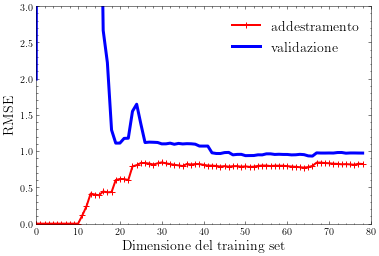

In [13]:
polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression()),
])

plt.figure(figsize=(6,4))
plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])

savefig("overfitting_learning_curves_plot", "pdf")
plt.show()

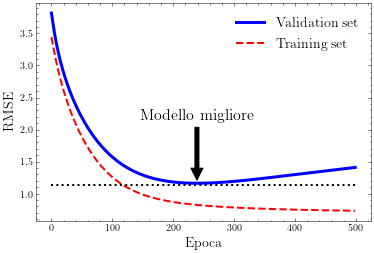

In [14]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

from copy import deepcopy

poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.figure(figsize=(6,4))
plt.annotate('Modello migliore',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
             )

best_val_rmse -= 0.03  # just to make the graph look better

plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoca", fontsize=14)
plt.ylabel("RMSE", fontsize=14)

savefig("early_stopping_plot", "pdf")
plt.show()

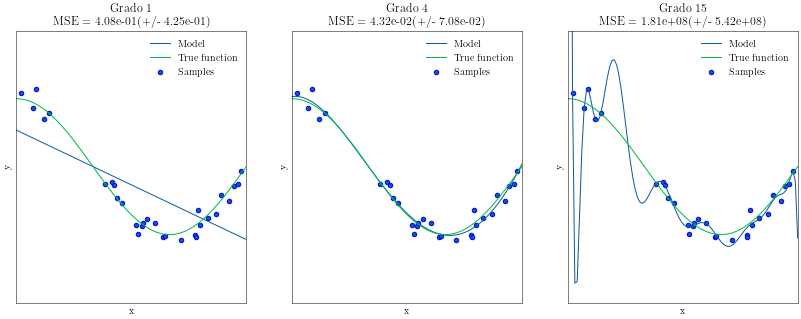

In [15]:
np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]
true_fun = lambda X : np.cos(1.5 * np.pi * X)

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using cross validation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)

    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Grado {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))

savefig("overfitting_underfitting", "pdf")
plt.show()